
------------------------------
 
 

This is derivd from 

  VScode_RunModel_IntervalTracks_to_KDE_19June2023_HalfDozen_iter0_2_epochs_1em-4
  
which is a copy of 

  VScode_RunModel_IntervalTracks_to_KDE_14June2023_HalfDozen_iter0_2_epochs_1em-4
  

but using 

  dataAA/20K_POCA_kernel_evts_200926.h5
  
rather than

  dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5
  
for train_loader (and last part of same input data file for validation)

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.1
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Wed Jun 21 13:04:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      On   | 00000000:01:00.0 Off |                    0 |
| N/A   21C    P0    31W / 250W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      On   | 00000000:25:00.0 Off |                    0 |
| N/A   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.10.1+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.8/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.1


### Set up local parameters

In [6]:
n_epochs = 500

# Name is the output file name


##  201019  mds
folder = '21June2023_VScode_HalfDozen_iter3_500epochs_2em5'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds
##  compared to 120 seconds with batch_size = 64 on 3090
##  so try batch_size = 64 again
# Size of batches

## A100 on sneezy is complaining about 20 GB with batch_size = 64,
## so reduce to 32;
## NB: problem was apparently due to CPU memory issue, not batch_size,
## so try with a larger batch size as an experiment
batch_size = 128
# How fast to learn
learning_rate = 2e-5

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
## collectdata_kde_Ellipsoids_29Aug2021 adds zBin and zOffset to X[]
## from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
##from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
## revert to traditional collect_t2kde_data
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
## use July 2022 version of collect_t2kde_data for testing stgructure
## (and later for modifying structure of X[] and Y[])
##from model.collectdata_kde_Ellipsoids_aug2022 import collect_t2kde_data
## 2023 version has torch.tensor(X,dtype=torch.float32), with tensor dtype defined
from model.collectdata_kde_Ellipsoids_aug2023 import collect_t2kde_data


## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.interval_kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(3)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 A100-PCIE-40GB


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss(epsilon=3e-6)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=100, bias=True)


Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE

## mds updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
## mds updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
## mds updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
## mds updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
## mds updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
## mds updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]


model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/21June2023_VScode_HalfDozen_iter3_500epochs_2em5
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias


In [16]:


pretrained_dict = torch.load('ML/20June2023_VScode_HalfDozen_iter2_500epochs_2em5/20June2023_VScode_HalfDozen_iter2_500epochs_2em5_final.pyt')

print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)


 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
pretrained_dict iterated


<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
## Training dataset. You can put as many files here as desired.
##  the code below copied from RunModel_IntervalTracks_to_KDE_08Aug2022_HalfDozen_iter0-testing-50epochs-1em4_repeat
## found on sleepy

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/100_POCA_kernel_evts_210829.h5',                                  
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                                  
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 800K intervals in a file with 20K events
                           slice = slice(None,700000)
                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
                            slice = slice(700000,None)
                           )

Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)


/data/home/sokoloff/.local/lib/python3.8/site-packages/awkward0/persist.py:509: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  schema = schema.tostring()


nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
 iEvt, nTrks =  0 211
 iEvt, iTrk =  0 0
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.050689124 0.025182785 0.025182785 0.0566
 iEvt, iTrk =  0 1
l_poca_m1(x,y,z)[iTrk], mag1 =  0.016311452 0.054198675 0.054198675 0.0566
 iEvt, iTrk =  0 2
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.03238572 -0.046419017 -0.046419017 0.0566
 iEvt, iTrk =  0 3
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.050279 0.025991969 0.025991969 0.0566
 iEvt, iTrk =  0 4
l_poca_m1(x,y,z)[iTrk], mag1 =  0.054919373 -0.013690238 -0.013690238 0.0566
 iEvt, nTrks =  1 21
 iEvt, iTrk =  1 0
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.033528615 -0.04560035 -0.04560035 0.0566
 iEvt, iTrk =  1 1
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.056321375 0.005609166 0.005609166 0.0566
 iEvt, iTrk =  1 2
l_poca_m1(x,y,z)[iTrk], mag1 =  0.00830551 0.055987306 0.055987306 0.0566
 iEvt, iTrk =  1 3
l_poca_m1(x,y,z)[iTrk], mag1 =  0.0

len(X_ints) = 800000
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 77.85 s
outer loop X_intervals.shape =  (800000, 9, 150)
Constructing 700000 event dataset took 0.2225 s
x_t_intervals.shape =  torch.Size([700000, 9, 150])
x_t_intervals.shape[0] =  700000
x_t_intervals.shape[1] =  9
y_t_intervals.shape =  torch.Size([700000, 100])
y_t_intervals.shape[0] =  700000
y_t_intervals.shape[1] =  100
Loading data...
  
kernel.shape =  (20000, 4000)
kernel.shape[0] =  20000
kernel.shape[1] =  4000
Y.shape =       (20000, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (800000, 100)
pocaMx.shape =  (20000,)
nEvts =  20000
pocaz.shape =  (20000,)
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
 iEvt, nTrks =  0 211
 iEvt, iTrk =  0 0
l_poca_m1(x,y,z)[iTrk], mag1 =  -0.050689124 0.025182785 0.025182785 0.0566
 iEvt, iTrk =  0 1
l_poca_m1(x,y,z)[iTrk], mag1 =  0.016311452 0.054198675 0.

len(X_ints) = 800000
len(Xlist_ints) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 77.95 s
outer loop X_intervals.shape =  (800000, 9, 150)
Constructing 100000 event dataset took 0.04653 s
x_t_intervals.shape =  torch.Size([100000, 9, 150])
x_t_intervals.shape[0] =  100000
x_t_intervals.shape[1] =  9
y_t_intervals.shape =  torch.Size([100000, 100])
y_t_intervals.shape[0] =  100000
y_t_intervals.shape[1] =  100


with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


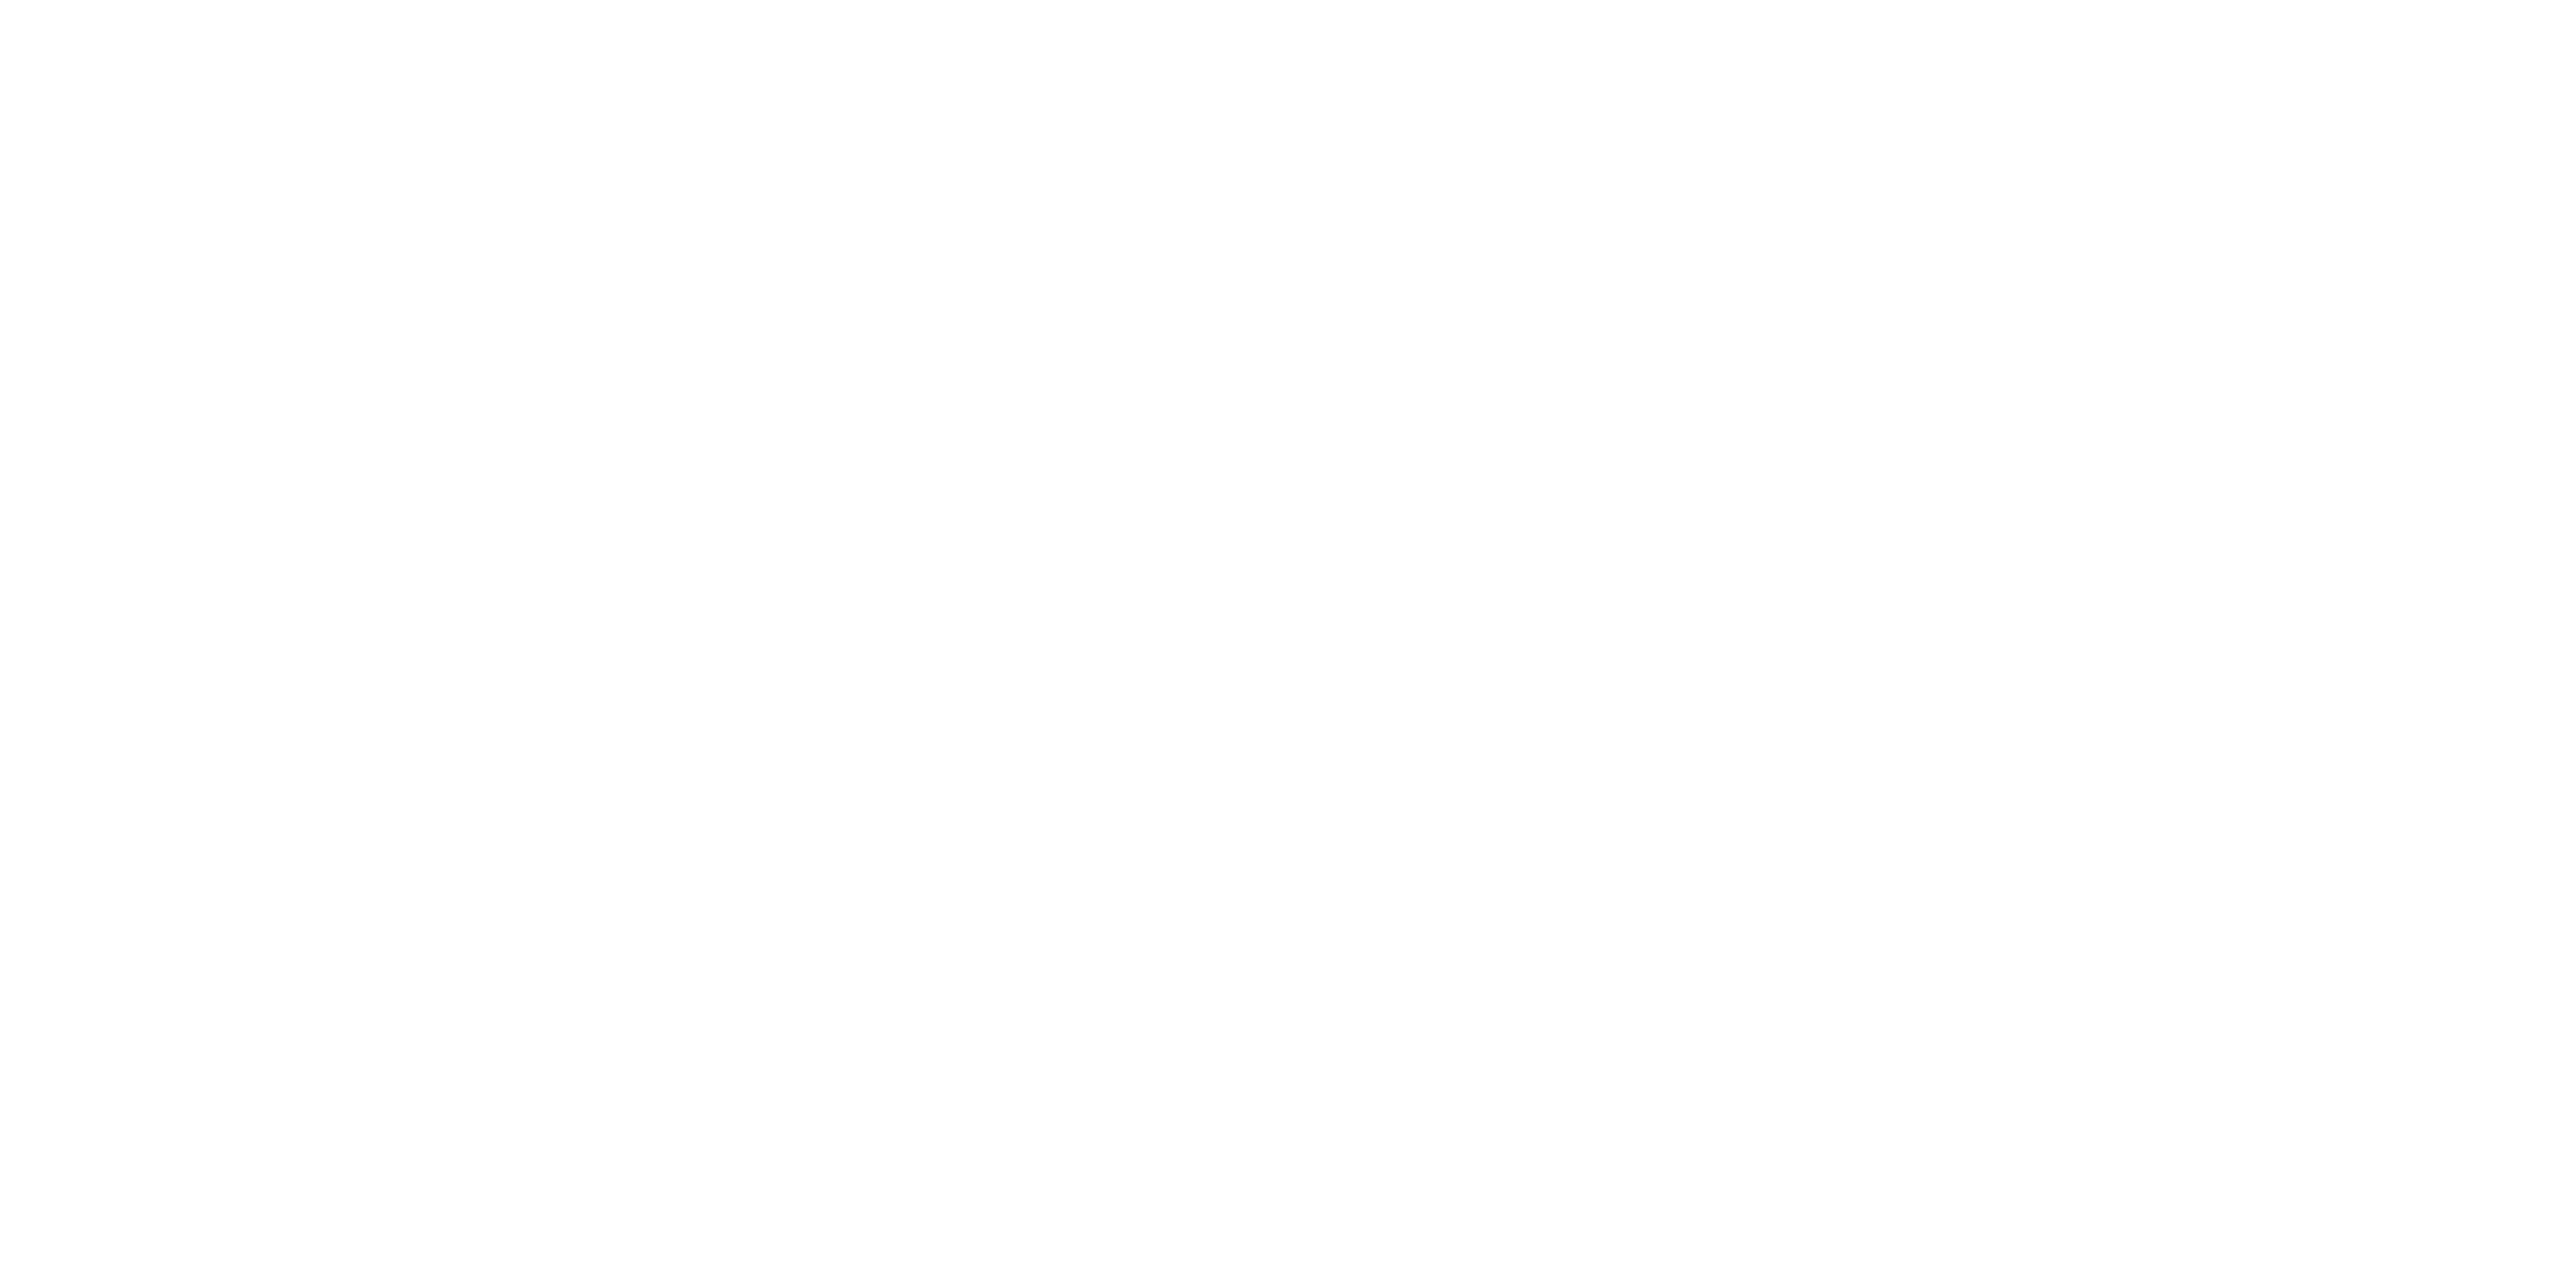

In [18]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [19]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 5469, val = 782
Number of batches: train = 5469, val = 782
Epoch 0: train=0.338766, val=0.338255, took 54.656 s
Epoch 1: train=0.338734, val=0.338301, took 29.956 s
Epoch 2: train=0.338716, val=0.338313, took 32.057 s
Epoch 3: train=0.338719, val=0.338341, took 32.151 s
Epoch 4: train=0.338699, val=0.338269, took 41.247 s
Epoch 5: train=0.338684, val=0.338436, took 32.526 s
Epoch 6: train=0.338703, val=0.338485, took 33.903 s
Epoch 7: train=0.338695, val=0.338471, took 30.805 s
Epoch 8: train=0.338686, val=0.338399, took 30.914 s
Epoch 9: train=0.338689, val=0.338406, took 37.872 s
Epoch 10: train=0.338675, val=0.338377, took 40.489 s
Epoch 11: train=0.338671, val=0.338307, took 38.984 s
Epoch 12: train=0.338676, val=0.338332, took 46.97 s
Epoch 13: train=0.338663, val=0.338282, took 34.444 s
Epoch 14: train=0.338652, val=0.338342, took 32.652 s
Epoch 15: train=0.338643, val=0.338351, took 29.97 s
Epoch 16: train=0.338651, val=0.338347, took 29.733 s
Epoch 17

Epoch 151: train=0.337949, val=0.337672, took 31.749 s
Epoch 152: train=0.337934, val=0.337695, took 30.679 s
Epoch 153: train=0.337936, val=0.337661, took 34.747 s
Epoch 154: train=0.337922, val=0.337662, took 28.48 s
Epoch 155: train=0.337929, val=0.337632, took 31.168 s
Epoch 156: train=0.337908, val=0.337623, took 32.844 s
Epoch 157: train=0.337911, val=0.337633, took 35.282 s
Epoch 158: train=0.337904, val=0.337673, took 31.419 s
Epoch 159: train=0.337904, val=0.337673, took 31.563 s
Epoch 160: train=0.337891, val=0.337687, took 29.789 s
Epoch 161: train=0.337878, val=0.337664, took 32.91 s
Epoch 162: train=0.337867, val=0.337668, took 33.668 s
Epoch 163: train=0.337866, val=0.337621, took 33.034 s
Epoch 164: train=0.337868, val=0.337562, took 29.134 s
Epoch 165: train=0.337865, val=0.337592, took 28.131 s
Epoch 166: train=0.337857, val=0.337576, took 34.683 s
Epoch 167: train=0.33785, val=0.337541, took 31.15 s
Epoch 168: train=0.337849, val=0.337539, took 29.059 s
Epoch 169: tra

Epoch 301: train=0.337169, val=0.336797, took 31.385 s
Epoch 302: train=0.337171, val=0.336852, took 29.191 s
Epoch 303: train=0.337162, val=0.336793, took 35.769 s
Epoch 304: train=0.337147, val=0.336746, took 29.498 s
Epoch 305: train=0.337153, val=0.336743, took 28.599 s
Epoch 306: train=0.337144, val=0.336712, took 29.561 s
Epoch 307: train=0.337149, val=0.336731, took 29.112 s
Epoch 308: train=0.337136, val=0.336779, took 27.912 s
Epoch 309: train=0.337132, val=0.336744, took 28.952 s
Epoch 310: train=0.337134, val=0.33676, took 27.436 s
Epoch 311: train=0.337132, val=0.336759, took 29.058 s
Epoch 312: train=0.337132, val=0.336773, took 29.045 s
Epoch 313: train=0.337131, val=0.336791, took 27.839 s
Epoch 314: train=0.33712, val=0.336825, took 27.693 s
Epoch 315: train=0.33712, val=0.336752, took 30.591 s
Epoch 316: train=0.337109, val=0.336765, took 27.893 s
Epoch 317: train=0.337103, val=0.336729, took 27.9 s
Epoch 318: train=0.337104, val=0.336728, took 28.456 s
Epoch 319: trai

Epoch 452: train=0.336588, val=0.336033, took 32.652 s
Epoch 453: train=0.336583, val=0.336035, took 32.657 s
Epoch 454: train=0.336579, val=0.336045, took 27.724 s
Epoch 455: train=0.336588, val=0.33607, took 34.208 s
Epoch 456: train=0.336584, val=0.336065, took 29.913 s
Epoch 457: train=0.336581, val=0.336052, took 31.487 s
Epoch 458: train=0.336579, val=0.336056, took 29.603 s
Epoch 459: train=0.33658, val=0.336009, took 31.858 s
Epoch 460: train=0.336581, val=0.336004, took 31.055 s
Epoch 461: train=0.336576, val=0.336046, took 32.572 s
Epoch 462: train=0.336574, val=0.336065, took 31.861 s
Epoch 463: train=0.336567, val=0.336064, took 30.66 s
Epoch 464: train=0.336568, val=0.336009, took 29.908 s
Epoch 465: train=0.336561, val=0.336008, took 37.412 s
Epoch 466: train=0.336553, val=0.336024, took 30.099 s
Epoch 467: train=0.336552, val=0.336024, took 32.372 s
Epoch 468: train=0.336557, val=0.336038, took 29.56 s
Epoch 469: train=0.336547, val=0.335978, took 30.889 s
Epoch 470: tra

Go ahead and save the final model (even though it was also saved above):

In [20]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [21]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


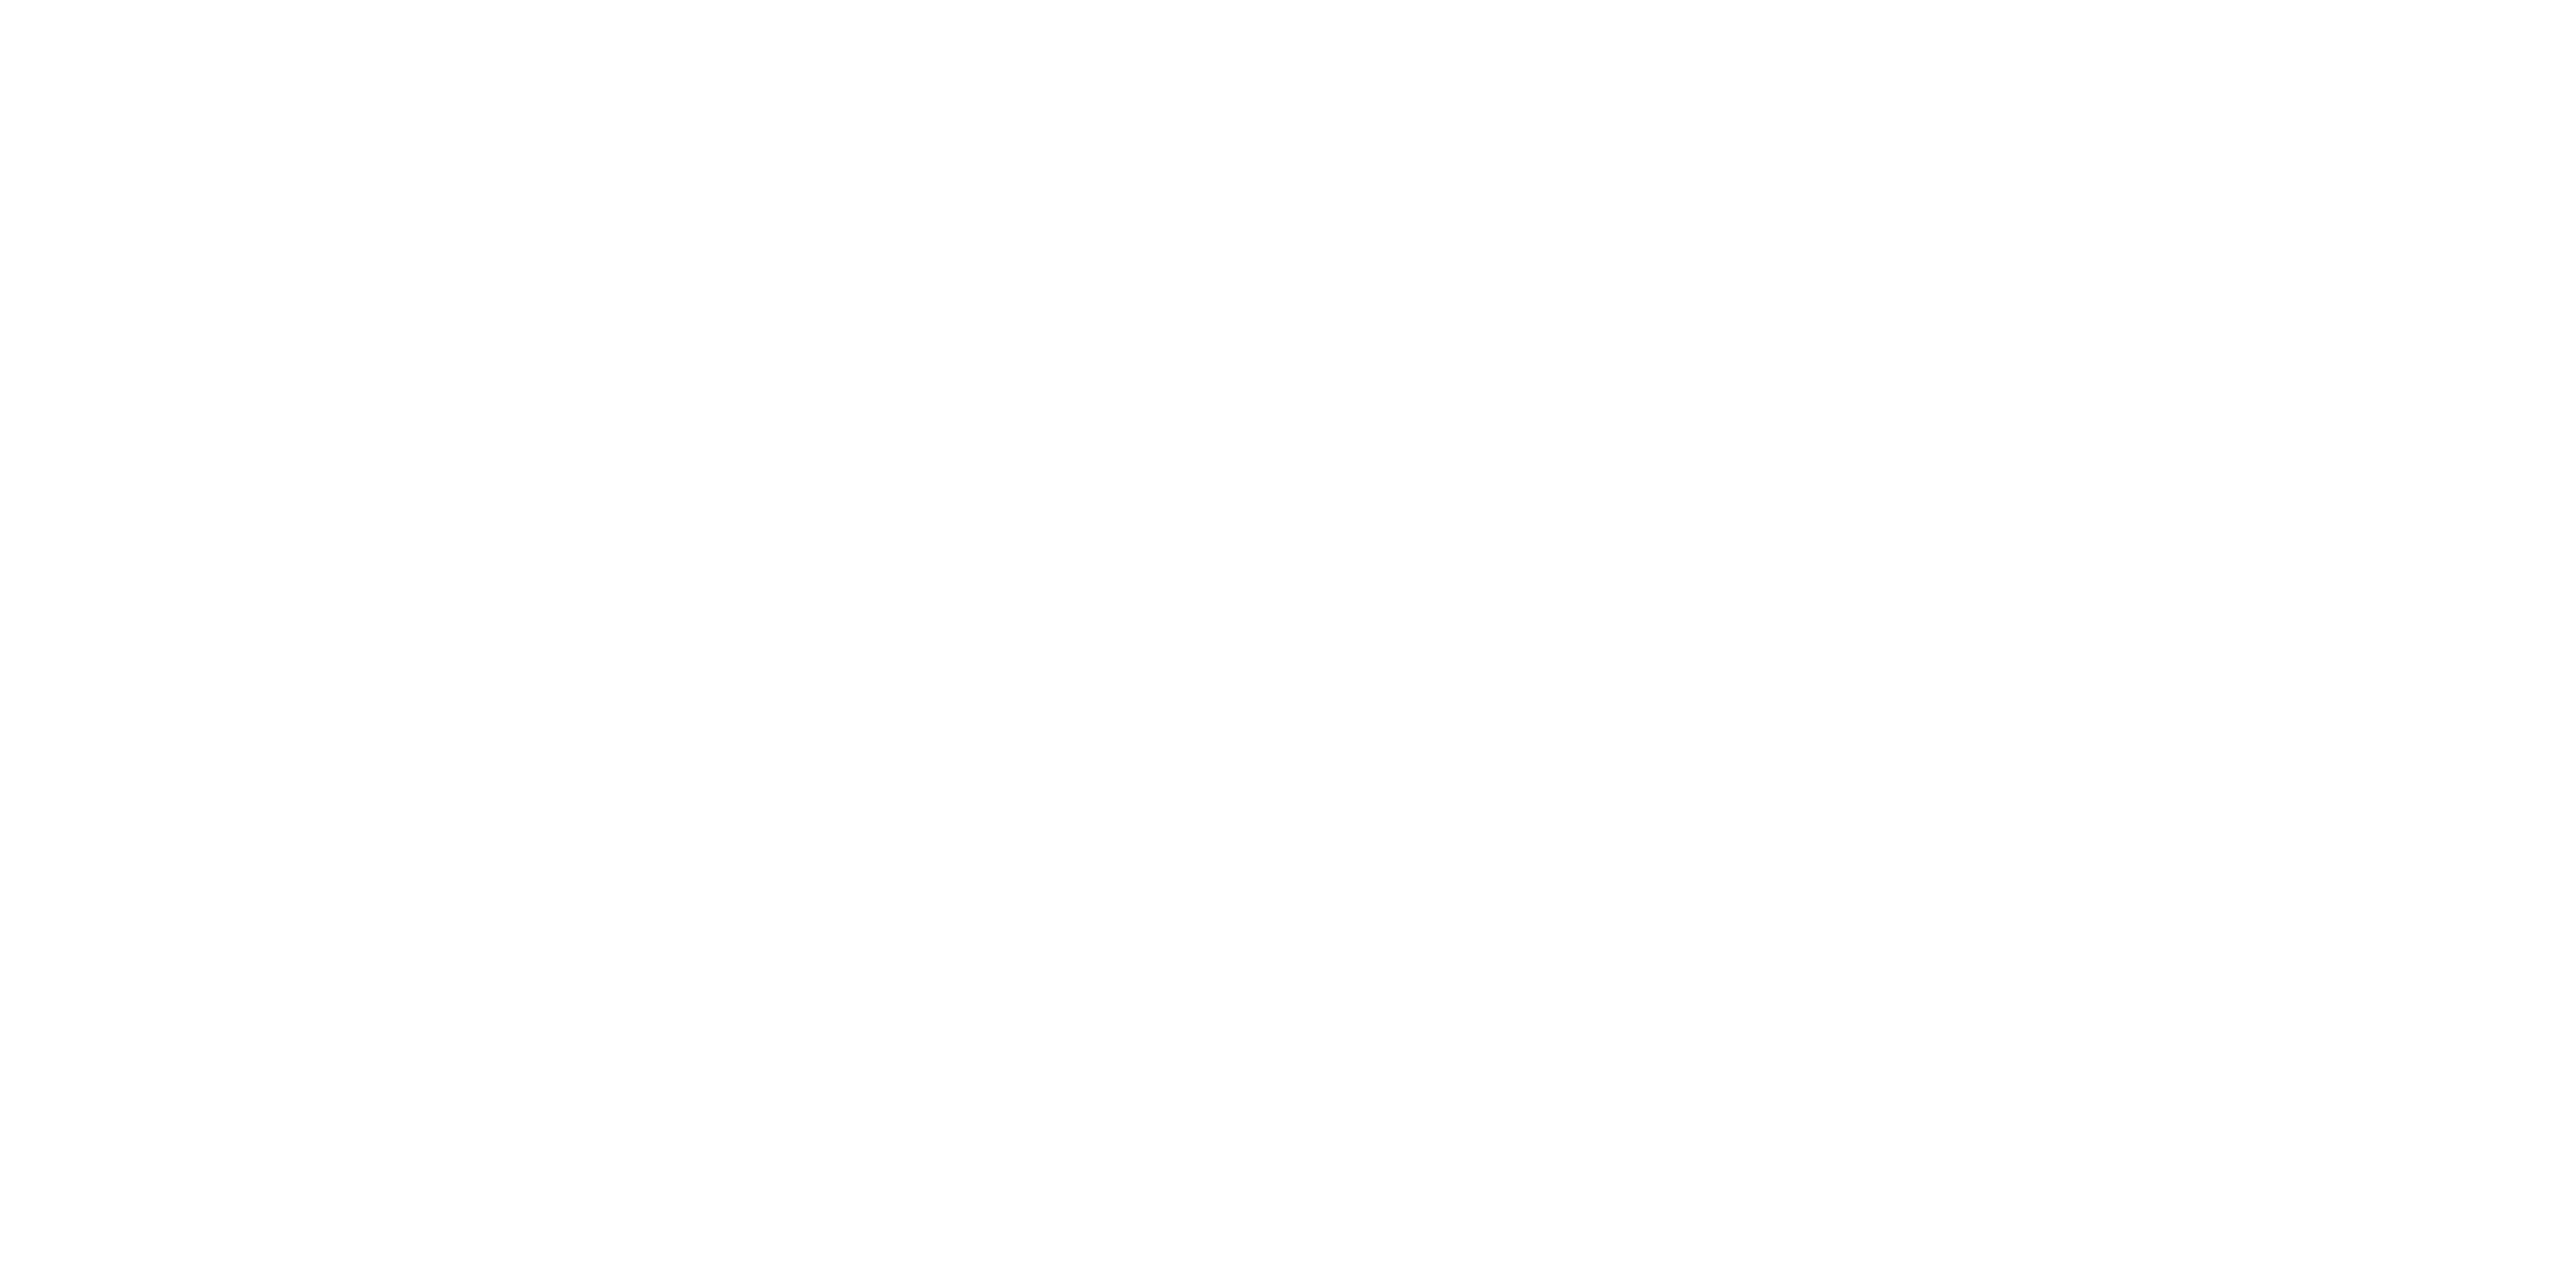

In [22]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [23]:
quit()
